In [165]:
import time

import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def forward_stage_wise(x, y, max_iters):
    selected_features = []
    residual = y.copy()
    answer_score = float('-inf')

    for _ in range(max_iters):
        print(f"Iteration {_}")
        best_feature = None
        best_score = float('-inf')

        # Iterating through unselected column and finding best one (with maximal impact on final precision)
        for feature in x.columns.difference(selected_features):
            model = LinearRegression()
            model.fit(x[[feature]], residual)
            predicted_residual = model.predict(x[[feature]])
            score = r2_score(residual, predicted_residual)

            if score > best_score:
                best_score = score
                best_feature = feature

        answer_score = max(answer_score, best_score)

        selected_features.append(best_feature)

        model = LinearRegression()
        model.fit(x[selected_features], y)
        residual = y - model.predict(x[selected_features])

    return selected_features, answer_score

In [166]:
from sklearn.metrics import r2_score

def forward_stage_wise_qr(x, y, max_iters):
    selected_features = []
    residual = y.copy()
    answer_score = float('-inf')

    for _ in range(max_iters):
        print(f"Iteration {_}")
        best_feature = None
        best_score = float('-inf')

        # Iterating through unselected column and finding best one (with maximal impact on final precision)
        for feature in x.columns.difference(selected_features):
            # Candidate feature matrix
            candidate = x[[feature]].values

            q, r = np.linalg.qr(candidate, mode='reduced')
            beta = np.linalg.solve(r, q.T @ residual)  # Solve R*beta = Q.T*res
            predicted_residual = candidate @ beta

            score = r2_score(residual, predicted_residual)

            if score > best_score:
                best_score = score
                best_feature = feature

        answer_score = max(answer_score, best_score)

        selected_features.append(best_feature)

        # Updating residual
        candidate = x[selected_features].values
        q, r = np.linalg.qr(candidate, mode='reduced')
        beta = np.linalg.solve(r, q.T @ y)
        residual = y - candidate @ beta

    return selected_features, answer_score


In [167]:
def get_xy(
        n_samples,
        n_features,
        n_target_features,
        norm_params,
        exp_params,
        scaling_limits_norm,
        scaling_limits_exp,
        noise_params_norm,
        noise_params_exp,
        target_function,
        target_noise
):
    np.random.seed(42)

    # Generate base distributions
    origin_norm = np.random.normal(**norm_params, size=n_samples)
    origin_exp = np.random.exponential(**exp_params, size=n_samples)

    dataset = np.zeros((n_samples, n_features))

    for i in range(n_features // 2):
        norm_new = origin_norm * np.random.uniform(*scaling_limits_norm) + \
                   np.random.normal(**noise_params_norm, size=n_samples)
        exp_new = origin_exp * np.random.uniform(*scaling_limits_exp) + \
                  np.random.normal(**noise_params_exp, size=n_samples)

        dataset[:, 2 * i] = norm_new
        dataset[:, 2 * i + 1] = exp_new

    column_names = [f"f_{i + 1}" for i in range(n_features)]
    data = pd.DataFrame(dataset, columns=column_names)

    # Generate the target vector
    exclude = data.iloc[:, :n_target_features]
    m_x = data.iloc[:, n_target_features:]

    exclude_array = exclude.to_numpy()
    weights = np.random.uniform(-1, 1, size=exclude_array.shape[1])

    # Apply the user-defined target function
    target = target_function(exclude_array, weights)

    # Add noise to the target
    m_y = target + np.random.normal(**target_noise, size=exclude_array.shape[0])

    return m_x, m_y

In [168]:
print("Running FSW...")
t1 = time.time()

n_samples = 10000
n_features = 1000
n_target_features = 100
norm_params = {"loc": 0, "scale": 1}
exp_params = {"scale": 1}
scaling_limits_norm = (0.1, 3.0)
scaling_limits_exp = (0.1, 4.0)
noise_params_norm = {"loc": 0, "scale": 0.2}
noise_params_exp = {"loc": 0, "scale": 0.4}
target_function = lambda x, w: np.dot(x, w)  # Linear function
target_noise = {"loc": 0, "scale": 0.1}

X, Y = get_xy(
    n_samples=n_samples,
    n_features=n_features,
    n_target_features=n_target_features,
    norm_params=norm_params,
    exp_params=exp_params,
    scaling_limits_norm=scaling_limits_norm,
    scaling_limits_exp=scaling_limits_exp,
    noise_params_norm=noise_params_norm,
    noise_params_exp=noise_params_exp,
    target_function=target_function,
    target_noise=target_noise
)

f1, s1 = forward_stage_wise(X, Y, 5)
print(f'score: {s1}, time: {time.time() - t1} seconds')

print("Running FSW-QR...")
t2 = time.time()
f2, s2 = forward_stage_wise_qr(X, Y, 5)
print(f'Score: {s2}, time: {time.time() - t2} seconds')

Running FSW...
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
score: 0.8744215593293443, time: 6.456685781478882 seconds
Running FSW-QR...
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Score: 0.8743508894535981, time: 1.9364838600158691 seconds


As you can see, latter method (with QR decomposition) is significantly faster than standard-way regression while displaying the accuracy

### Adjusting dataset size

Running FSW-QR for 5000
Iteration 0
Iteration 1
Iteration 2
Running FSW-QR for 10000
Iteration 0
Iteration 1
Iteration 2
Running FSW-QR for 20000
Iteration 0
Iteration 1
Iteration 2


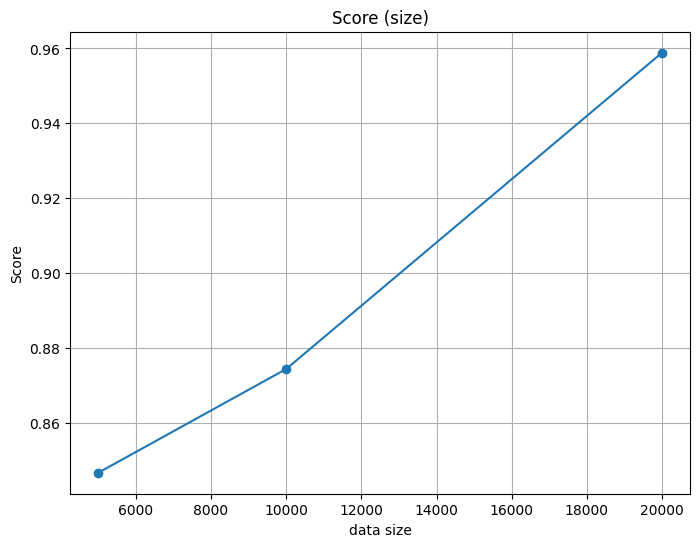

In [169]:
# Examining function SCORE(DATASET_SIZE)

n_samples_list = [5000, 10000, 20000]

scores = []

for n_samples in n_samples_list:
    print(f"Running FSW-QR for {n_samples}")
    m_x, m_y = get_xy(
        n_samples=n_samples,
        n_features=n_features,
        n_target_features=n_target_features,
        norm_params=norm_params,
        exp_params=exp_params,
        scaling_limits_norm=scaling_limits_norm,
        scaling_limits_exp=scaling_limits_exp,
        noise_params_norm=noise_params_norm,
        noise_params_exp=noise_params_exp,
        target_function=target_function,
        target_noise=target_noise,
    )
    
    f, s = forward_stage_wise(m_x, m_y, 3)
    
    scores.append(s)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(n_samples_list, scores, marker='o')
plt.title("Score (size)")
plt.xlabel("data size")
plt.ylabel("Score")
plt.grid(True)
plt.show()